In [1]:
import pandas as pd
from sklearn import linear_model
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn import linear_model,ensemble,metrics,preprocessing
import numpy as np
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
import cv2
from ImageFeatures import *
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Hand labeling images
main_images=pd.read_csv('HighRes_ManuallyLabeled.csv')
main_images.drop('Unnamed: 0',axis=1,inplace=True)

#Image features
image_features = pd.read_csv('HighRes_ImageFeatures.csv')
image_features.drop('Unnamed: 0',axis=1,inplace=True)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/matplotlib/__init__.py:1035: UserWarning: Duplicate key in file "/Users/richardknoche/.matplotlib/matplotlibrc", line #2
  (fname, cnt))


In [2]:
#Merge the two df
df = main_images.merge(image_features,how="inner",on="path")

In [3]:
len(df[df['Rating']==3])

461

In [4]:
#Combine the two dataframe
features = ['g_xgrad', 'r_ygrad', 'g_ygrad', 'Complimentary_Color_Level', 'B_Width', 'Salient_Saturation',
            'H_mean', 'b_xgrad', 'Thirds_Vertical_Saliency_Sym', 'Lapacian_Hue', 'Lapacian_Value',
            'Thirds_Horizontal_Value_Sym', 'R_xgrad', 'b_ygrad_std', 'Horizontal_Hue_Sym', 'Vertical_Value_Sym',
            'r_ygrad_std', 'Thirds_Vertical_Value_Sym', 'S_var', 'Thirds_Sat', 'b_xgrad_std', 'Image_Size',
            'Thirds_Saliency', 'S_mean', 'Thirds_Vertical_Saturation_Sym', 'Thirds_Hue', 'Thirds_Vertical_Hue_Sym',
            'Vertical_Hue_Sym', 'standard_luminance', 'Laplacian_Sharpness', 'Aspect_Ratio', 'Thirds_Value',
            'FFT_Sharpness', 'Thirds_To_Focal_Distance', 'G_Width', 'r_xgrad_std', 'Lapacian_Saturation',
            'Horizontal_Saturation_Sym', 'H_var', 'V_mean', 'V_var', 'Salient_Hue', 'G_Mean', 'Histogram_Darkness',
            'Colorfulness', 'percieved_luminace', 'Salient_Value', 'Busyness', 'g_xgrad_std', 'R_Width', 'Number_of_Contours',
            'g_ygrad_std', 'b_ygrad', 'B_Mean', 'Horizontal_Value_Sym', 'Thirds_Horizontal_Saliency_Sym',
            'Thirds_Horizontal_Hue_Sym', 'Vertical_Saturation_Sym', 'R_Mean', 'Thirds_Horizontal_Saturation_Sym']


In [5]:
#Drop na and edited images
df.dropna(inplace=True)
edited_df = df[df['Rating']==4]
df=df[df['Rating']<4]

In [6]:
#Change to "acceptable or not" labels
df['Rating']=df['Rating']==3
edited_df['Rating']=True

In [7]:
col_to_predict = 'Rating'

num_minority = min(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))
num_majority = max(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))

true_df = df[df[col_to_predict]==True]
false_df = df[df[col_to_predict]==False]


In [8]:
samp = "down"

if samp == "down":
    #Downsampling
    col_to_predict = 'Rating'

    num_minority = min(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))
    num_majority = max(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))

    true_df = df[df[col_to_predict]==True]
    false_df = df[df[col_to_predict]==False]
    
    train_true = true_df.sample(n=np.floor(num_minority*0.6),random_state = 102)
    #train_false = false_df.sample(n=np.floor(2*num_minority*0.7),random_state = 102) #Using 2*num_minority, since we supliment later
    train_false = false_df.sample(n=np.floor(num_minority*0.6),random_state = 102) #Using 2*num_minority, since we supliment later

    train = pd.concat([train_true,train_false])
    test = df.drop(train.index)

    #Add some edited images to the training set boost sample size
    #train = pd.concat([train,edited_df.iloc[:int(num_minority*0.7)]])
    
    #Making sure the ratio in the test set is accurate
    test1 = test[test['Rating']==1]
    test2 = test[test['Rating']==0].sample(n=np.floor(len(test1)*num_majority/num_minority))
    test = pd.concat([test1,test2])

elif samp == "up":
    #Upsampling
    col_to_predict = 'Rating'

    num_minority = min(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))
    num_majority = max(len(df[df[col_to_predict]==False]),len(df[df[col_to_predict]==True]))

    true_df = df[df[col_to_predict]==True]
    false_df = df[df[col_to_predict]==False]

    train_true = true_df.sample(frac=0.6,random_state = 102)
    train_true = pd.concat([train_true]*np.ceil(num_majority/num_minority))
    train_false = false_df.sample(frac=0.6,random_state = 102)


    train = pd.concat([train_true,train_false])
    test = df.drop(train.index)

/Users/richardknoche/anaconda/lib/python3.5/site-packages/pandas/core/generic.py:2644: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  locs = rs.choice(axis_length, size=n, replace=replace, p=weights)


Accuracy:  0.657681940701
0.452008052583


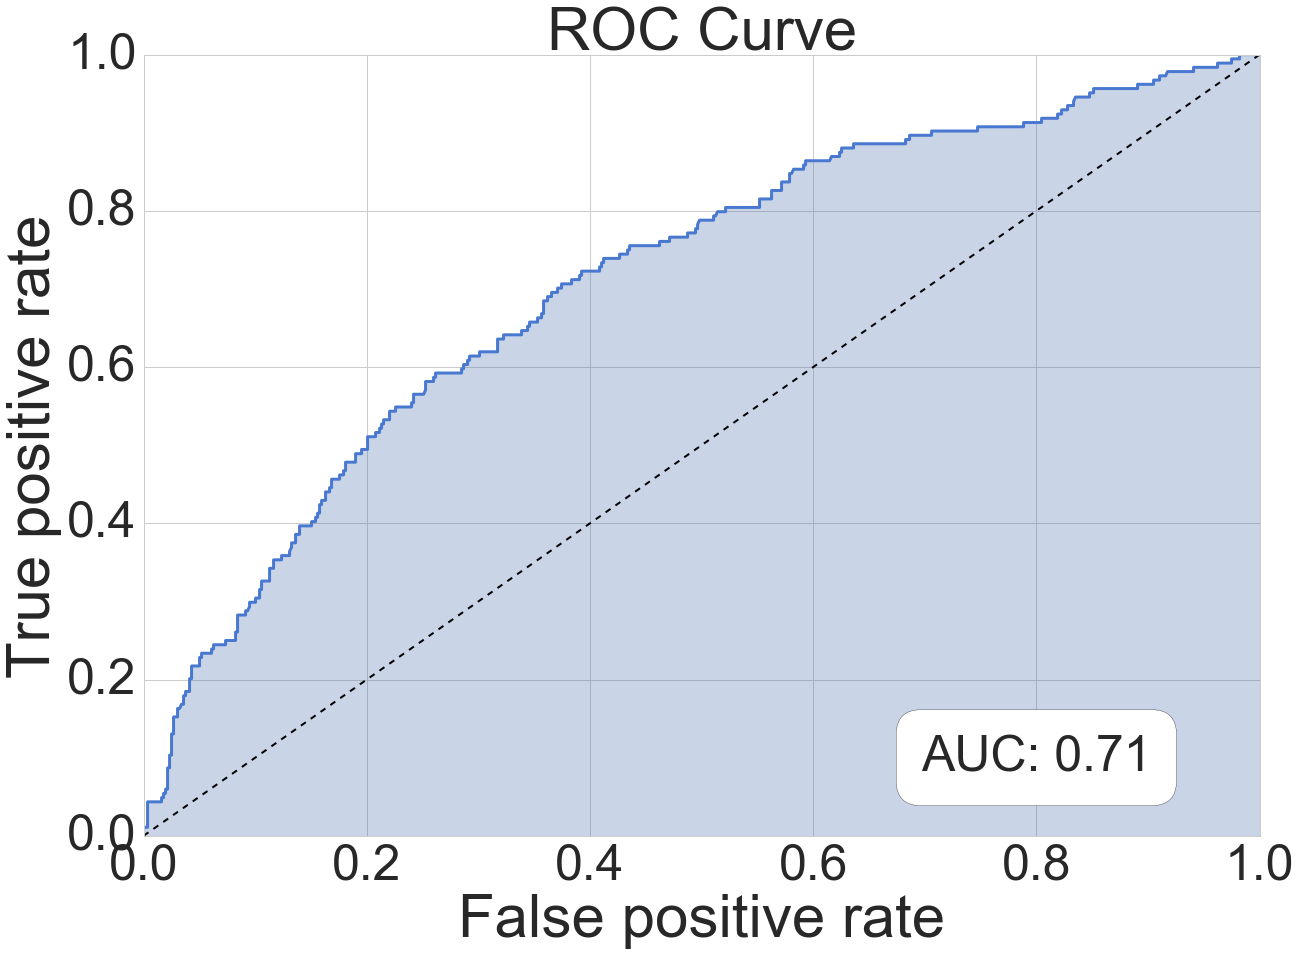

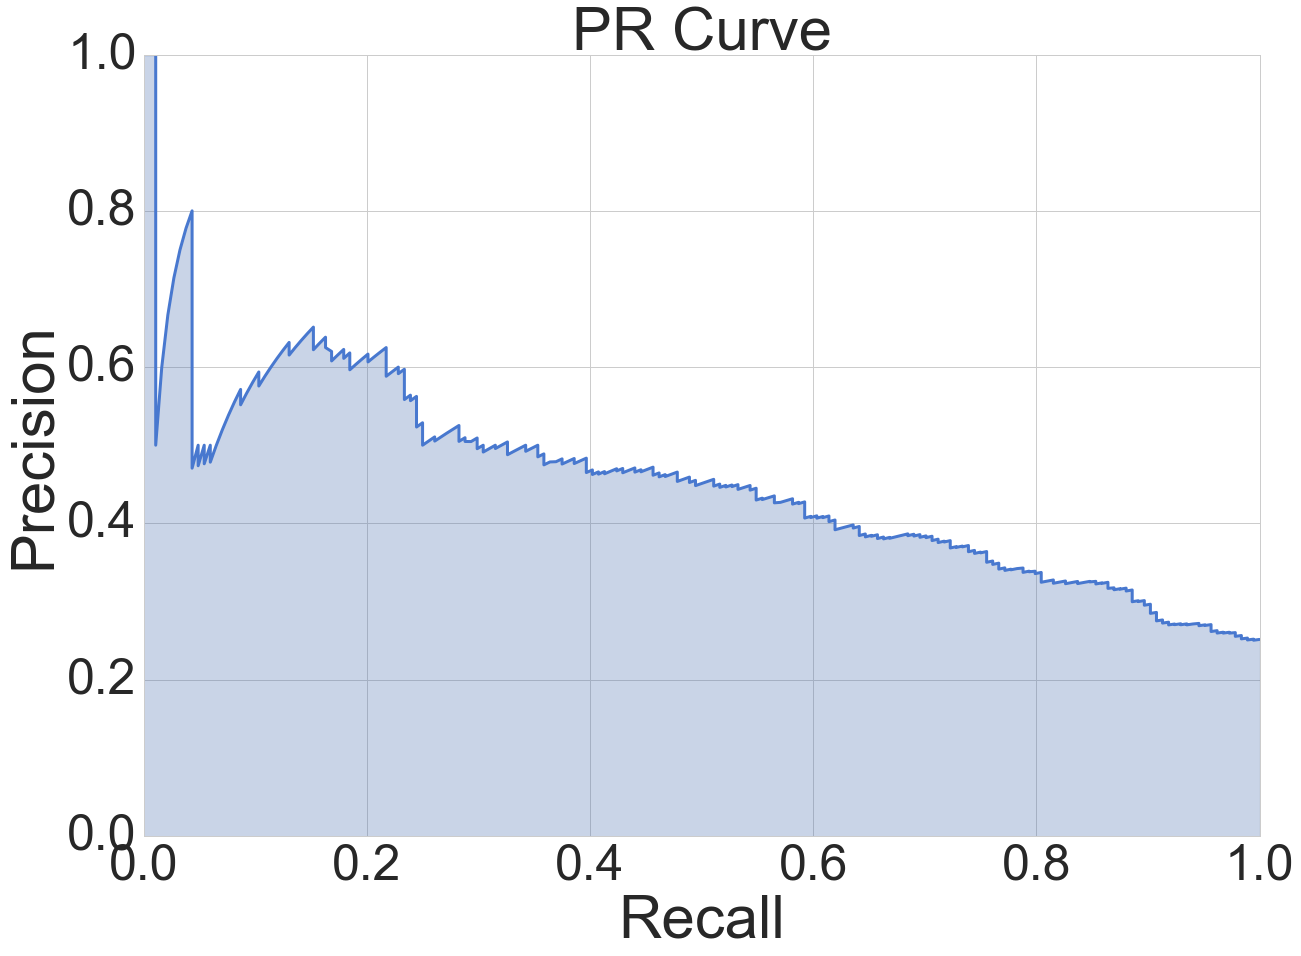

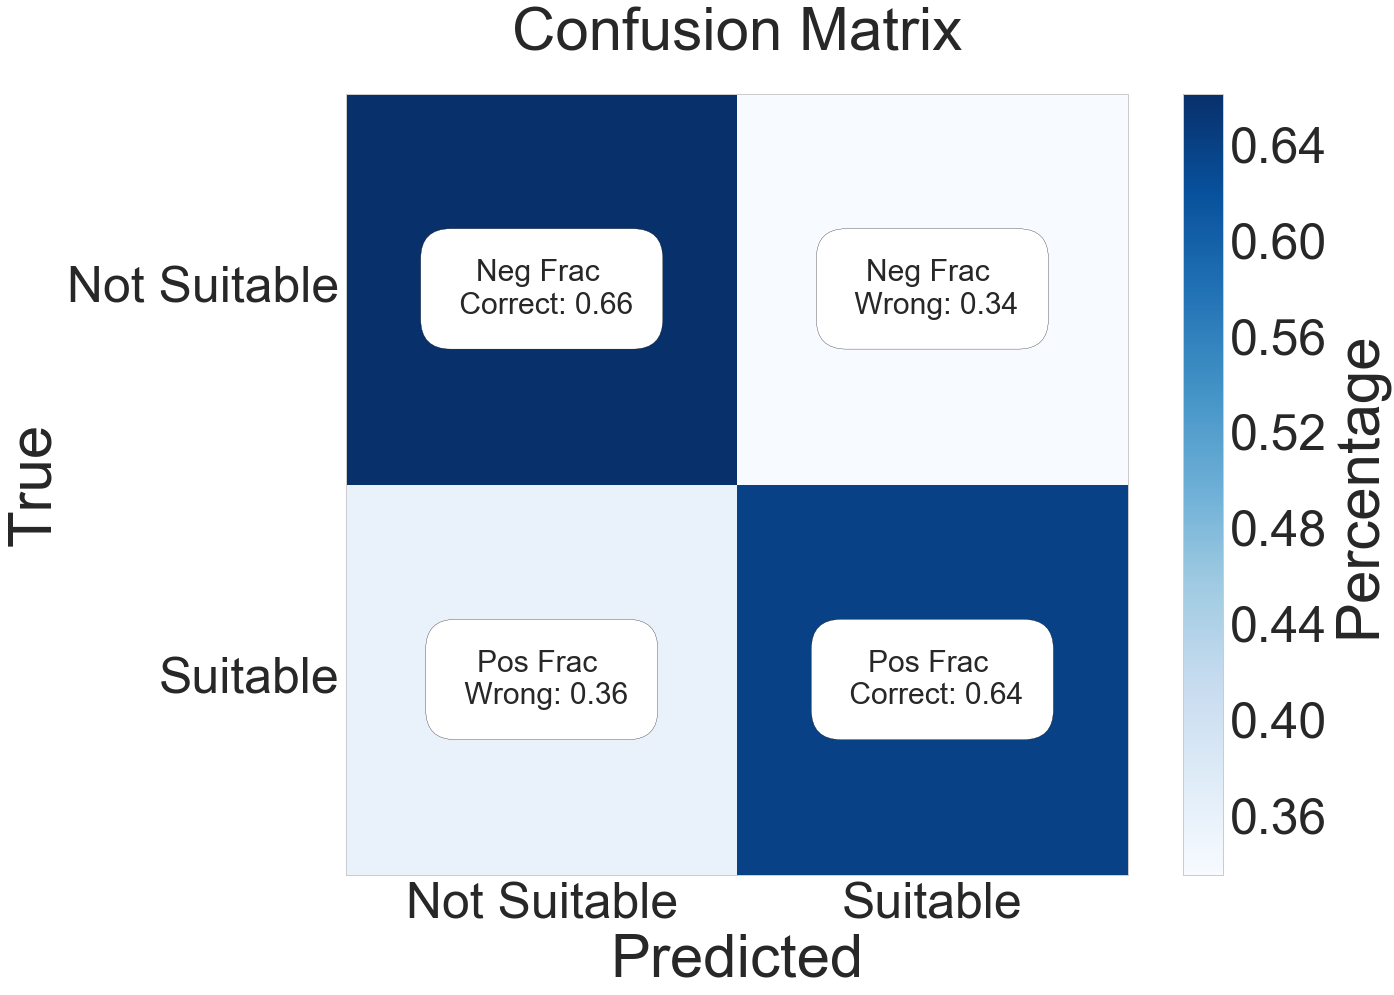

Frac that are good above 0.5:  0.38562091503267976
Improvement factor:  0.35169491525423735


In [19]:
train_x = train[features]
train_y = train[col_to_predict]

test_x = test[features]
test_y = test[col_to_predict]

#cv_x = cv[features]
#cv_y = cv['view_rate']

#Normalize features
std_scale = preprocessing.StandardScaler().fit(train_x)
minmax_scale = preprocessing.MinMaxScaler().fit(train_x)

train_x_std = std_scale.transform(train_x)
train_x_minmax = minmax_scale.transform(train_x)

test_x_std = std_scale.transform(test_x)
test_x_minmax = minmax_scale.transform(test_x)

train_x_features = train_x
test_x_features = test_x

#Train Model

clf = ensemble.AdaBoostClassifier(
    ensemble.RandomForestClassifier(
        criterion = 'entropy',n_estimators=500,min_samples_leaf=2,max_features=None,random_state=102)
    )
clf.fit(train_x_features,train_y)
predicted_y = clf.predict(test_x_features)
y_probs =clf.predict_proba(test_x_features)[:, 1]

#ROC
fpr, tpr, thresholds = metrics.roc_curve(test_y, y_probs)
sns.set_style("whitegrid")
blue, = sns.color_palette("muted", 1)
fig = plt.figure(figsize=(20,14))
ax = plt.gca()
ax.plot(fpr, tpr, color=blue, lw=3)
ax.fill_between(fpr, 0, tpr, alpha=.3)
ax.plot([0, 1], [0, 1], 'k--', lw=2)
ax.set_xlabel('False positive rate',size=60)
ax.set_ylabel('True positive rate',size=60)
ax.set_title('ROC Curve',size=60)
ax.set_xticklabels(np.linspace(0,1,6),size=50)
ax.set_yticklabels(np.linspace(0,1,6),size=50)
ax.text(0.8,0.1,"AUC: %0.2f" % metrics.auc(fpr, tpr),va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=0.5'),size=50)
fig.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/ROC.png')


#Accuracy, Precision, Recall
print('Accuracy: ',clf.score(test_x_features,test_y))
f1score, tpr, thresholds = metrics.roc_curve(test_y, y_probs)

precision, recall, thresholds = precision_recall_curve(test_y,y_probs)
average_precision = average_precision_score(test_y, y_probs)
print(average_precision)


#Prec-Recall Curve
fig = plt.figure(figsize=(20,14))
ax = plt.gca()
ax.plot(recall, precision, color=blue, lw=3)
ax.fill_between(recall, 0, precision, alpha=.3)
ax.set_xlabel('Recall',size=60)
ax.set_ylabel('Precision',size=60)
ax.set_title('PR Curve',size=60)
ax.set_xticklabels(np.linspace(0,1,6),size=50)
ax.set_yticklabels(np.linspace(0,1,6),size=50)
fig.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/PR.png')


precision, recall, fscore, support = metrics.precision_recall_fscore_support(test_y, predicted_y)
classifier_metrics = pd.DataFrame( {'Precision' : precision, 'Recall' : recall, 'F-Score' : fscore, 'Support' : support})
classifier_metrics.index=['Bad','Good']
classifier_metrics

import pylab as pl
labels = ['Not Suitable', 'Suitable']

cm = metrics.confusion_matrix(test_y, predicted_y)
cm = (cm[0]/np.sum(cm[0]),cm[1]/np.sum(cm[1]))


fig = plt.figure(figsize=(20,14))
ax = plt.gca()
ax.grid(False)
ax = fig.add_subplot(111)
cax = ax.matshow(cm,cmap='Blues')
pl.title('Confusion Matrix',size=60)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel('Percentage',size=60)
cbar.ax.tick_params(labelsize=50) 
ax.set_xticklabels([''] + labels,size=50)
ax.set_yticklabels([''] + labels,size=50)
ax.xaxis.set_ticks_position('bottom')
pl.xlabel('Predicted',size=60)
pl.ylabel('True',size=60)



pl.text(0,0,'Neg Frac \n Correct: %.2f'% cm[0][0],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
pl.text(0,1,'Pos Frac \n Wrong: %.2f'% cm[1][0],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
pl.text(1,0,'Neg Frac \n Wrong: %.2f'% cm[0][1],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)
pl.text(1,1,'Pos Frac \n Correct: %.2f'% cm[1][1],va='center',ha='center',bbox=dict(fc='w',boxstyle='round,pad=1'),size=30)

pl.show()
fig.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/ConfusionMatrix.png')

test['IsEdit_Prob']=clf.predict_proba(test[features])[:,1]
bad_df=test[test['Rating']==False]
good_df=test[test['Rating']==True]
frac_good = len(good_df[good_df['IsEdit_Prob']>0.5])/(len(bad_df[bad_df['IsEdit_Prob']>0.5]) + len(good_df[good_df['IsEdit_Prob']>0.5]))
print('Frac that are good above 0.5: ', frac_good)
print('Improvement factor: ', (1/0.25- 1/frac_good)/(1/0.25))

In [10]:
import pickle
save = True
if save == True:
    with open('image_classifier.pkl', 'wb') as f:
        pickle.dump(clf, f)

    with open('image_classifier_features.pkl', 'wb') as f:
        pickle.dump(features, f)

In [11]:
classifier_metrics

,F-Score,Precision,Recall,Support
Bad,0.743434,0.851852,0.659498,558
Good,0.485830,0.387097,0.652174,184


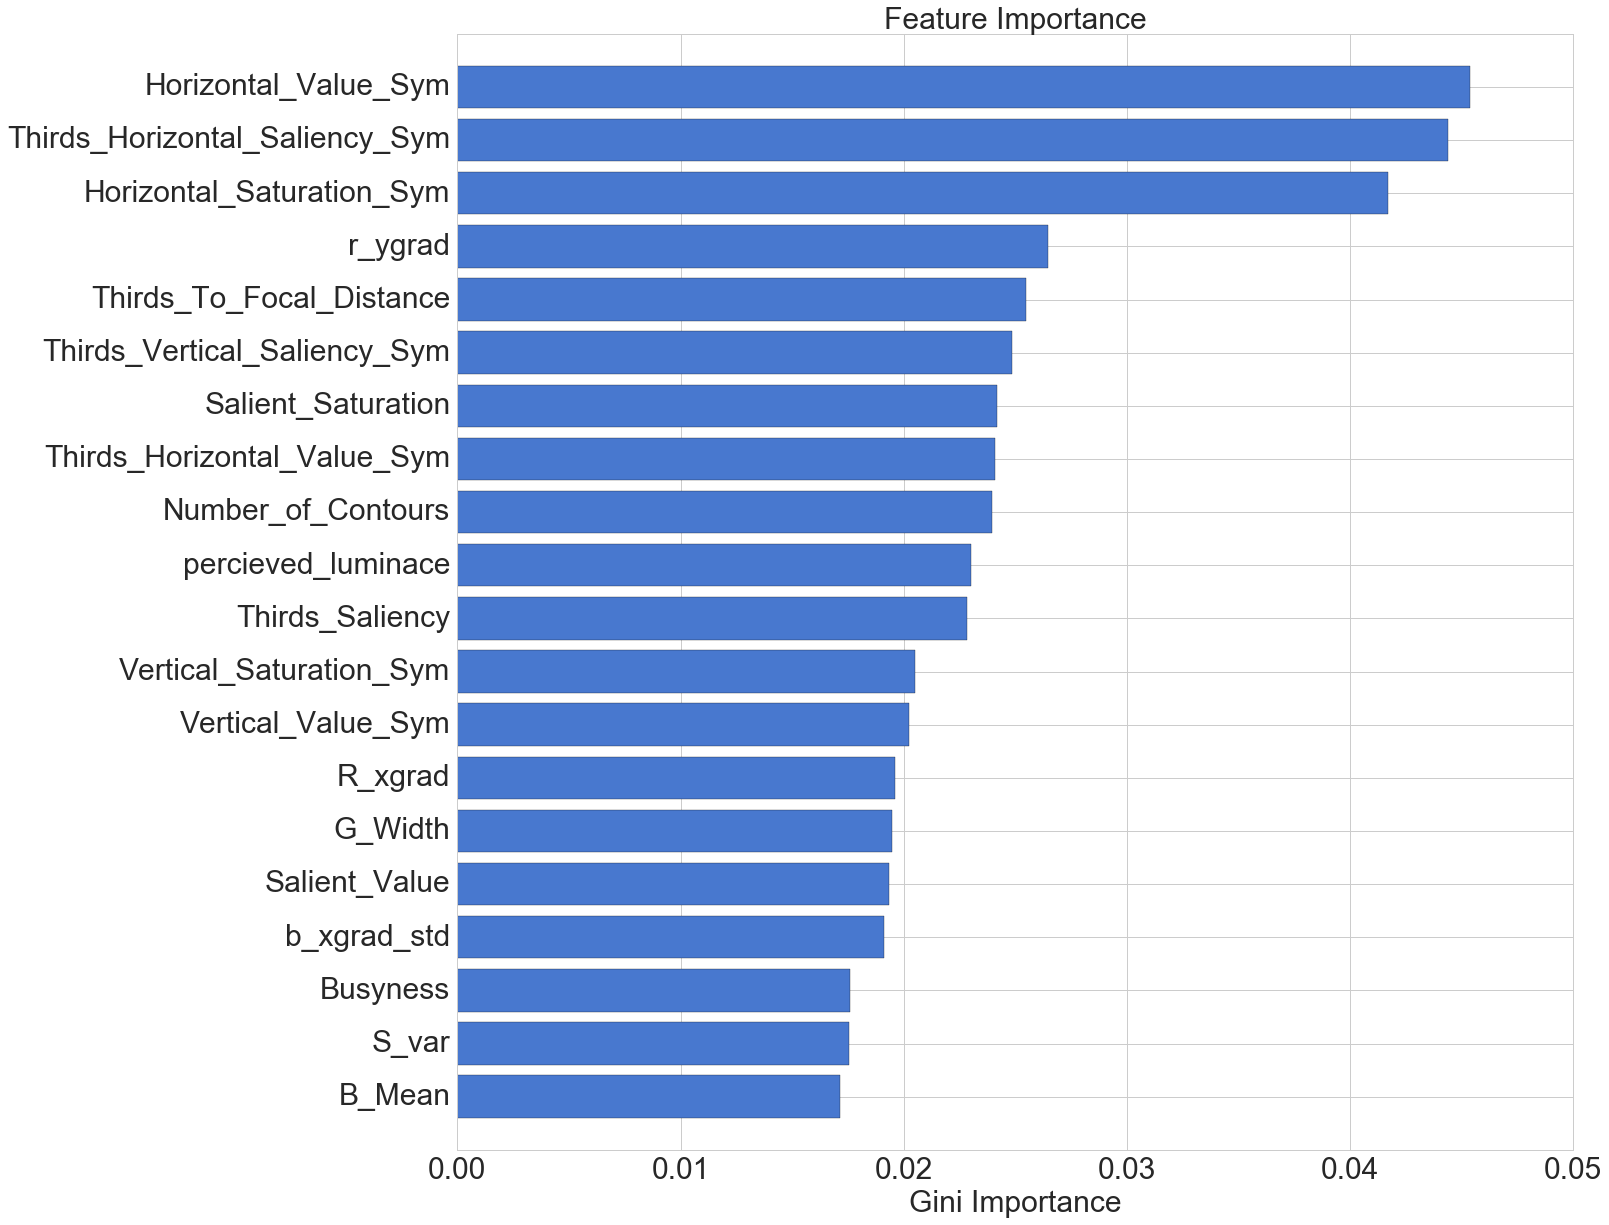

In [30]:
#Show top 15 features
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

sorted_importances = [importance for (importance,feature) in sorted(zip(importances,features),reverse=True)]
sorted_features = [feature for (importance,feature) in sorted(zip(importances,features),reverse=True)]   

sorted_importances = sorted_importances[:20]
sorted_features = sorted_features[:20]
plt.figure(figsize=(20,20))
plt.title("Feature Importance",size=30)
plt.barh(range(len(sorted_features),0,-1), sorted_importances,
       color=blue, align="center")
plt.yticks(range(len(sorted_features),0,-1),size=14)
plt.xlabel('Gini Importance',size=30)
ax=plt.gca()
ax.tick_params(labelsize=30) 
ax.set_yticklabels(sorted_features)
plt.ylim([0, len(sorted_features)+1])
plt.savefig('/Users/richardknoche/Desktop/DecoRaterSlides/FeatureImporance.png',bbox_inches='tight')
plt.show()


# Test to see if it picks out good rankings

In [ ]:
test['PredictedClass']=clf.predict(test[features])
test['IsEdit_Prob']=clf.predict_proba(test[features])[:,1]


In [ ]:
bins=np.arange(0,1,0.04)

# Plot the histogram.
y,x,_ = plt.hist(test['IsEdit_Prob'],bins=bins, normed=False, alpha=.3, color=[1,1,1])
x=(x[1:]+x[:-1])/2 # for len(x)==len(y)

_,_,_ = plt.hist(test[test['Rating']==False]['IsEdit_Prob'],bins=bins,alpha=0.5,color='r')
_,_,_ = plt.hist(test[test['Rating']==True]['IsEdit_Prob'],bins=bins,alpha=0.5,color='g')

plt.show()

In [ ]:
good_df=test[test['Rating']==True]
bad_df=test[test['Rating']==False]

In [ ]:
#Catches ~70% of the good images, and removes about 62% of the bad ones at thresh=50%

In [ ]:
len(good_df[good_df['IsEdit_Prob']>0.5])/len(good_df)

In [ ]:
len(bad_df[bad_df['IsEdit_Prob']>0.5])/len(bad_df)

In [ ]:
#Accidentally miss ~30% of good images

In [ ]:
len(good_df[good_df['IsEdit_Prob']<0.5])/len(good_df)

In [ ]:
#60% of the images above 0.5% thresh are good images
len(good_df[good_df['IsEdit_Prob']>0.5])/(len(bad_df[bad_df['IsEdit_Prob']>0.5]) + len(good_df[good_df['IsEdit_Prob']>0.5]))

In [ ]:
#33% of the images in general are good images -- so we increased efficiency by ~45%
len(good_df)/(len(bad_df)+len(good_df))

In [ ]:
(1/0.25- 1/0.35)/(1/0.25)

In [ ]:
#look at the listings

In [ ]:
#Compare within listings for all AptDeco images
sorted_df = test.sort_values('IsEdit_Prob')[['product_id_y','IsEdit_Prob','path']].dropna().reset_index()

#WORST IMAGES
for idx in range(0,20):
    print('%0.2f' % sorted_df.ix[idx,'IsEdit_Prob'],sorted_df.ix[idx,'path'])
    print('     ')

In [ ]:
#Compare within listings for all AptDeco images
sorted_df = test.sort_values('IsEdit_Prob',ascending=False)[['product_id_y','IsEdit_Prob','path']].dropna().reset_index()

#BEST IMAGES
for idx in range(0,20):
    print('%0.2f' % sorted_df.ix[idx,'IsEdit_Prob'],sorted_df.ix[idx,'path'])
    print('     ')

# Explaning results

In [ ]:
test.head()

In [ ]:

#From http://marcotcr.github.io/lime/tutorials/Tutorial%20-%20continuous%20and%20categorical%20features.html
from lime import lime_text,lime_tabular
from lime.lime_text import LimeTextExplainer
class_names=['Bad','Good']
explainer = lime_tabular.LimeTabularExplainer(np.array(train_x_features), feature_names=features, class_names=class_names, discretize_continuous=True)

idx = 50
df_idx = test.index[idx]
print('True class: %s' % class_names[test_y.loc[df_idx]])
print('Probability(Good) =', clf.predict_proba(test_x_features.loc[df_idx].values.reshape(1,-1))[0][1] )

exp = explainer.explain_instance(np.array(test_x_features.loc[df_idx]), clf.predict_proba, num_features=6)
exp.show_in_notebook(show_table=True, show_all=False,)

#Get Image
image = url_to_image(test.loc[df_idx]['path'])
image=CropImage(image)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

In [ ]:
#histograms of each features
for i in range(len(features)):
    feat = features[i]
    plt.figure()
    _,_,_ = plt.hist(df[df['Rating']==0][feat],bins=np.linspace(df[feat].min(),df[feat].max(),50),alpha=0.2,color='r')
    _,_,_ = plt.hist(df[df['Rating']==1][feat],bins=np.linspace(df[feat].min(),df[feat].max(),50),alpha=0.2,color='g')
    plt.title(feat)